In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
spark = SparkSession.builder.appName(
    'File Streaming Demo'
).master('local[3]').config(
    'spark.streaming.stopGracefullyOnShutdown', 'true'
).config(
    'spark.sql.shuffle.partitions', 3
).config(
    'spark.sql.streaming.schemaInference', 'true'
).getOrCreate()

23/08/06 14:32:08 WARN Utils: Your hostname, OMEN resolves to a loopback address: 127.0.1.1; using 172.19.181.52 instead (on interface eth0)
23/08/06 14:32:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/06 14:32:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
raw_df = spark.readStream.format('json').option(
    'path','input_dataset'
).option(
    'maxFilesPerTrigger','1'
).option('cleanSource','delete').load()

In [4]:
raw_df.printSchema()

root
 |-- CESS: double (nullable = true)
 |-- CGST: double (nullable = true)
 |-- CashierID: string (nullable = true)
 |-- CreatedTime: long (nullable = true)
 |-- CustomerCardNo: string (nullable = true)
 |-- CustomerType: string (nullable = true)
 |-- DeliveryAddress: struct (nullable = true)
 |    |-- AddressLine: string (nullable = true)
 |    |-- City: string (nullable = true)
 |    |-- ContactNumber: string (nullable = true)
 |    |-- PinCode: string (nullable = true)
 |    |-- State: string (nullable = true)
 |-- DeliveryType: string (nullable = true)
 |-- InvoiceLineItems: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- ItemCode: string (nullable = true)
 |    |    |-- ItemDescription: string (nullable = true)
 |    |    |-- ItemPrice: double (nullable = true)
 |    |    |-- ItemQty: long (nullable = true)
 |    |    |-- TotalValue: double (nullable = true)
 |-- InvoiceNumber: string (nullable = true)
 |-- NumberOfItems: long (nullable = t

In [5]:
explode_df = raw_df.selectExpr(
    'InvoiceNumber','CreatedTime','StoreID','PosID','CustomerType','PaymentMethod',
    'DeliveryType','DeliveryAddress.City','DeliveryAddress.State',
    'DeliveryAddress.PinCode','explode(InvoiceLineItems) as InvoiceLineItem'
)

In [6]:
explode_df.printSchema()

root
 |-- InvoiceNumber: string (nullable = true)
 |-- CreatedTime: long (nullable = true)
 |-- StoreID: string (nullable = true)
 |-- PosID: string (nullable = true)
 |-- CustomerType: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- DeliveryType: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- PinCode: string (nullable = true)
 |-- InvoiceLineItem: struct (nullable = true)
 |    |-- ItemCode: string (nullable = true)
 |    |-- ItemDescription: string (nullable = true)
 |    |-- ItemPrice: double (nullable = true)
 |    |-- ItemQty: long (nullable = true)
 |    |-- TotalValue: double (nullable = true)



In [7]:
def struct_to_col(df, struct_field):
    df = df.alias('temp')
    cols = df.select(f'{struct_field}.*').columns
    for col in cols:
        df = df.withColumn(col, F.expr(f'{struct_field}.{col}'))
    return df.drop(struct_field)

In [8]:
flattened_df = struct_to_col(explode_df, 'InvoiceLineItem')
flattened_df.printSchema()

root
 |-- InvoiceNumber: string (nullable = true)
 |-- CreatedTime: long (nullable = true)
 |-- StoreID: string (nullable = true)
 |-- PosID: string (nullable = true)
 |-- CustomerType: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- DeliveryType: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- PinCode: string (nullable = true)
 |-- ItemCode: string (nullable = true)
 |-- ItemDescription: string (nullable = true)
 |-- ItemPrice: double (nullable = true)
 |-- ItemQty: long (nullable = true)
 |-- TotalValue: double (nullable = true)



In [ ]:
invoice_writer_query = flattened_df.writeStream.format(
    'json'
).option(
    'path','output'
).option(
    'checkpointLocation','chk-point-dir'
).outputMode('append').queryName(
    'Flattened Invoice Writer'
).trigger(processingTime='1 minute').start()

invoice_writer_query.awaitTermination()

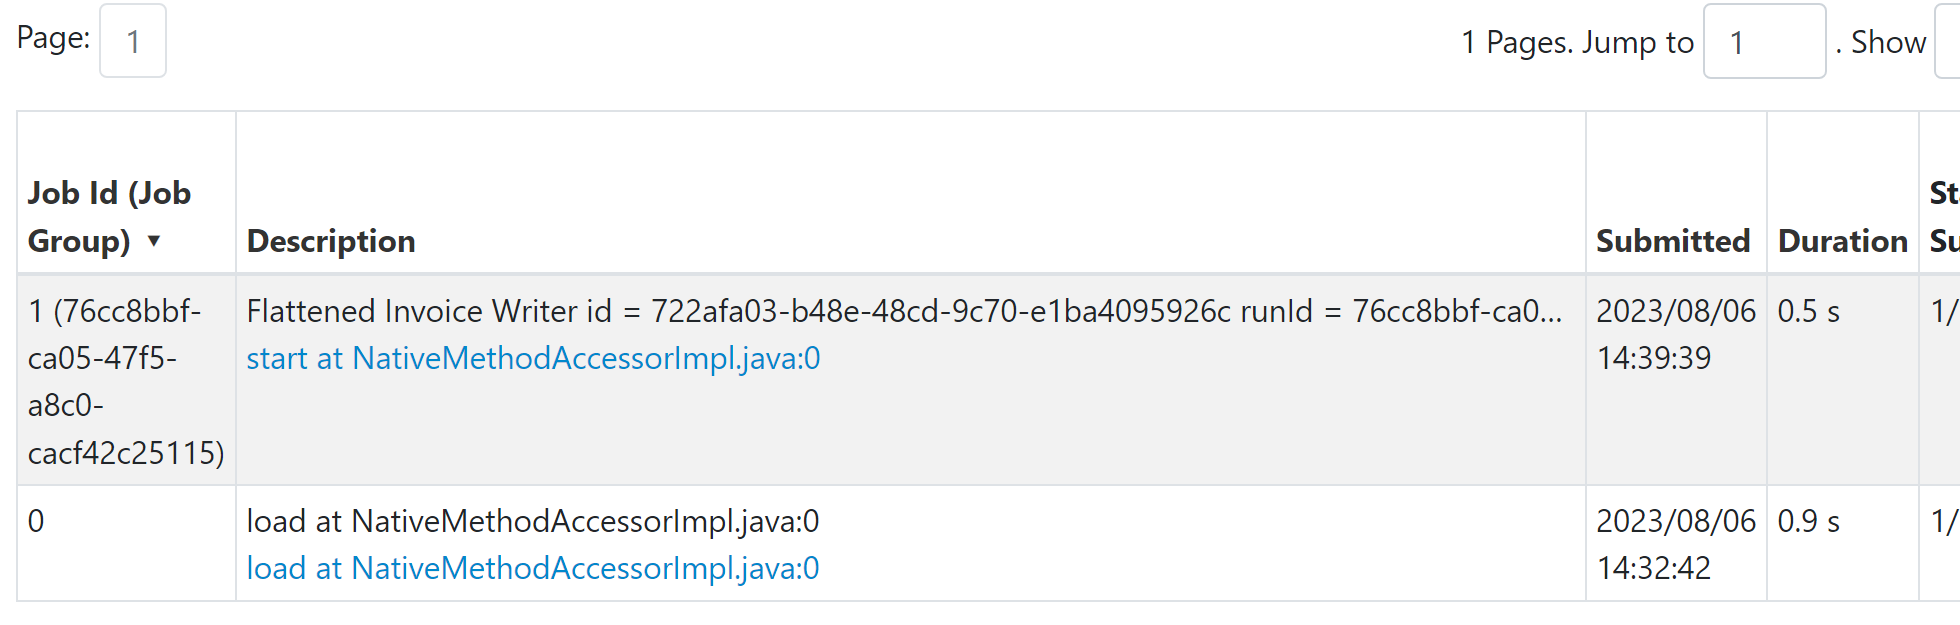